**Actividad 2:**

_Identificación de prendas de vestir con una red neuronal convolucional utilizando Fashion MNIST._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github.com/jpimilan/RNA/blob/main/Deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/jpimilan/RNA/blob/main/Deep_computer_vision_with_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
from tensorflow import keras

# Diseño y Entrenamiento de Convolutional Neural Network

Se carga el conjunto de datos Fashion MNIST de TensorFlow, se agrega una dimensión adicional a las imágenes y se cambia la escala de los valores de píxel de: 0-255 y 0-1.

## Implementación CNN

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(images, labels), (_, _) = fashion_mnist.load_data()
images = images[..., tf.newaxis]
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)
dataset = tf.data.Dataset.from_tensor_slices(images).batch(4)

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
images.shape

TensorShape([60000, 28, 28, 1])

In [4]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")

for batch in dataset:
    fmaps = conv_layer(batch)

In [5]:
fmaps.shape

TensorShape([4, 28, 28, 32])

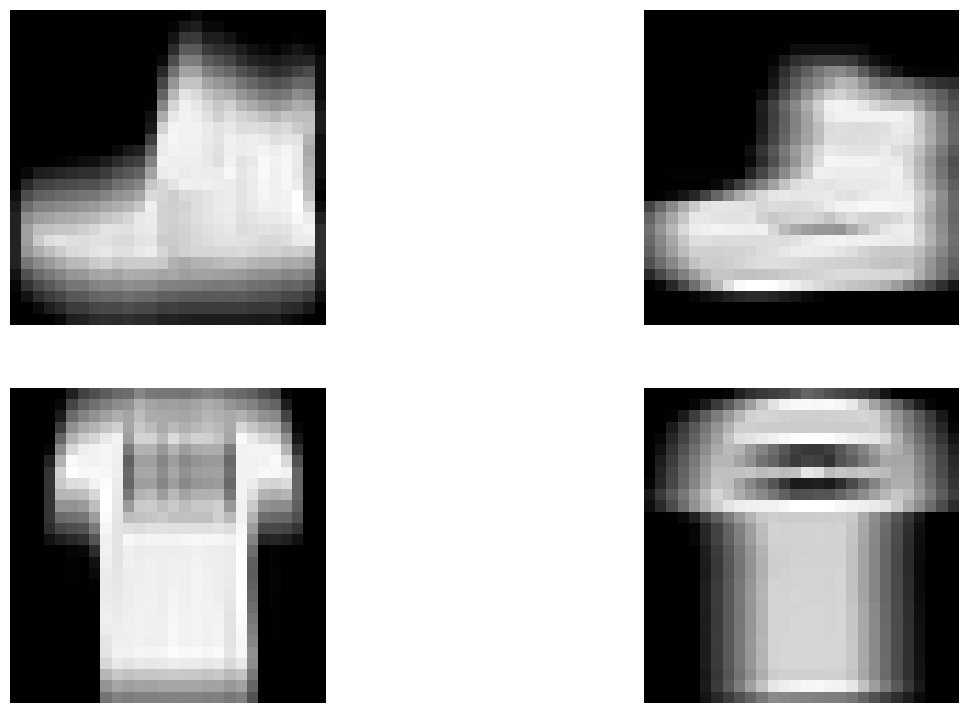

In [6]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 1, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Los filtros generados aleatoriamente suelen actuar como detectores de bordes y es una herramienta útil en el procesamiento de imágenes, y ese es el tipo de filtros con los que suele comenzar una capa convolucional. Durante el entrenamiento, el modelo aprende gradualmente, mejorando los filtros para reconocer patrones útiles.

Ahora usemos cero relleno:

In [7]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")

In [8]:
fmaps.shape

TensorShape([60000, 28, 28, 2])

In [9]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([60000, 14, 14, 32])

In [10]:
def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Veamos los pesos:

In [11]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 1, 32)

In [12]:
biases.shape

(32,)

In [13]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 1, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

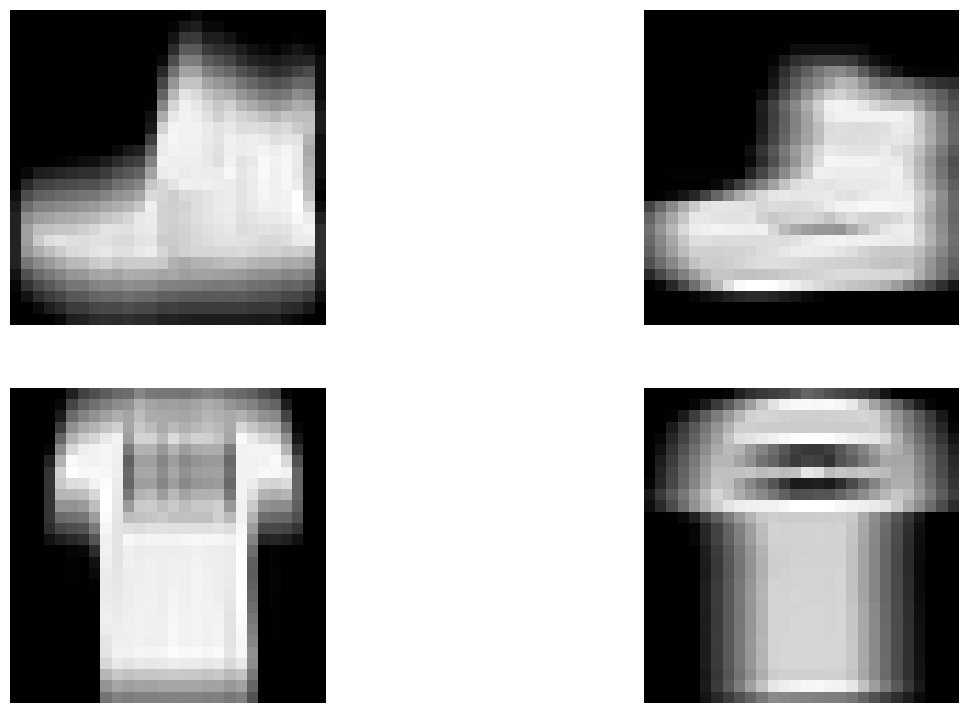

In [14]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 1, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Ahora se observan las líneas oscuras en la parte superior e inferior de los dos conjunto de imagenes. Esto se debe al hecho de que se utilizo cero relleno, mientras que no se utilizo cero relleno para crear los mapas de características en la figura anterior. Debido al relleno con ceros, los dos mapas de características basados ​​en el filtro de línea vertical (es decir, las dos imágenes de la izquierda) no pudieron activarse completamente cerca de la parte superior e inferior de las imágenes. De manera similar, los dos mapas de características basados ​​en el filtro de línea horizontal (es decir, las dos imágenes de la derecha) no pudieron activarse completamente cerca de la izquierda y la derecha de las imágenes.

## Pooling Layers
Implementación Pooling Layers con Keras

**Max pooling**

In [15]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [16]:
output = max_pool(images)

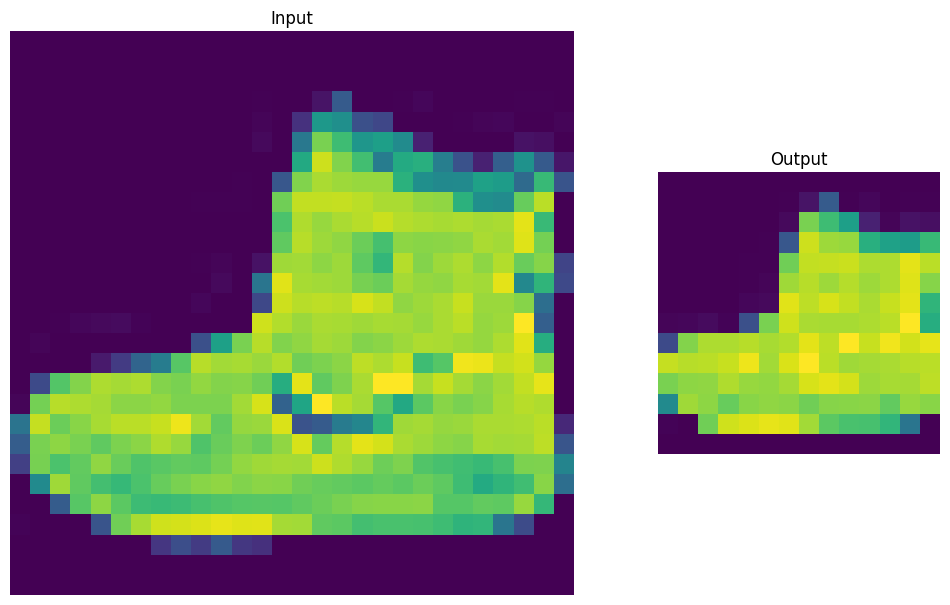

In [17]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])
ax2.axis("off")
plt.show()

**Depth-wise pooling**

In [18]:
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [19]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    def call(self, inputs):
        shape = tf.shape(inputs)
        if shape[-1] % self.pool_size != 0:
            raise ValueError(f"El tamaño del grupo {self.pool_size} debe ser un divisor del número de canales {shape[-1]}")
        groups = shape[-1] // self.pool_size
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [20]:
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

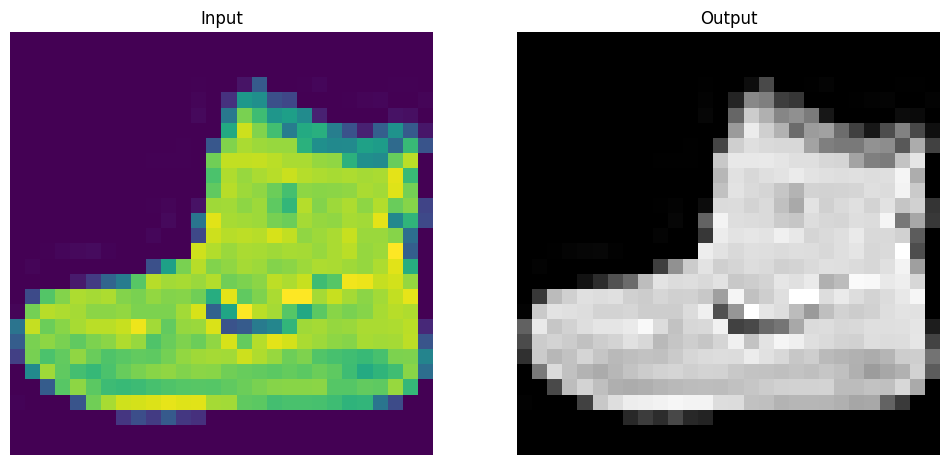

In [21]:
depth_output = DepthPool(pool_size=1)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")
plt.axis("off")
plt.show()

**Global Average Pooling**

In [22]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

La siguiente capa es equivalente::

In [23]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [24]:
global_avg_pool(images)

<tf.Tensor: shape=(60000, 1), dtype=float32, numpy=
array([[0.3813876 ],
       [0.42315927],
       [0.14336735],
       ...,
       [0.31285515],
       [0.16761705],
       [0.08345339]], dtype=float32)>

## Diferentes Arquitecturas CNN

**CNN con Fashion MNIST**

### Implementación de una CNN con 2 capas convolucionales (Corregir)

In [ ]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)



El siguiente modelo utiliza 2 capas convolucionales, seguidas de 1 capa de agrupación, luego un 25 % de abandono, luego una capa densa, otra capa de abandono pero con un 50 % de abandono y finalmente la capa de salida. Alcanza un 99,2 % de precisión en el conjunto de prueba. Esto coloca a este modelo aproximadamente en el 20 % superior en la [competencia MNIST Kaggle] (https://www.kaggle.com/c/digit-recognizer/) (si ignoramos los modelos con una precisión superior al 99,79 % que fueron probablemente entrenado en el conjunto de prueba, como lo explica Chris Deotte en [esta publicación] (https://www.kaggle.com/c/digit-recognizer/discussion/61480)). ¿Puedes hacerlo mejor? Para alcanzar una precisión del 99,5 al 99,7 % en el conjunto de prueba, debe agregar aumento de imagen, norma por lotes, usar un programa de aprendizaje como 1 ciclo y posiblemente crear un conjunto.

### Implementación de una CNN con Dropout

In [26]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [27]:
tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 29s 11ms/step - loss: 0.7125 - accuracy: 0.7523 - val_loss: 0.3558 - val_accuracy: 0.8692
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4150 - accuracy: 0.8616 - val_loss: 0.3138 - val_accuracy: 0.8898
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3519 - accuracy: 0.8828 - val_loss: 0.2930 - val_accuracy: 0.8928
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3097 - accuracy: 0.8955 - val_loss: 0.2561 - val_accuracy: 0.9046
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2883 - accuracy: 0.9012 - val_loss: 0.2651 - val_accuracy: 0.9080
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2656 - accuracy: 0.9105 - val_loss: 0.2874 - val_accuracy: 0.8980
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2511 - accuracy: 0.9149 - val_loss: 0.2436 - val_a

### Implementación de una CNN ResNet-34 usando Keras

In [29]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [30]:
model = keras.models.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

### Implementación de una CNN con Modelos preentrenados de Keras

In [31]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 6s 0us/step


In [32]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full[..., np.newaxis]
images = X_train_full[:2]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [33]:
images_rgb = tf.image.grayscale_to_rgb(images_resized)
inputs = tf.keras.applications.resnet50.preprocess_input(images_rgb)

In [34]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 2s 2s/step


(2, 1000)

In [35]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 [==============================] - 0s 0us/step
Image #0
  n02120079 - Arctic_fox   45.01%
  n02951585 - can_opener   16.40%
  n03498962 - hatchet      7.95%
Image #1
  n03595614 - jersey       44.13%
  n03197337 - digital_watch 11.35%
  n03075370 - combination_lock 4.52%


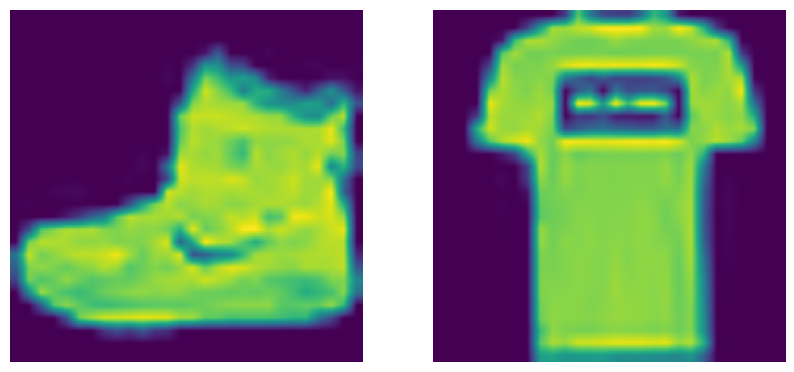

In [36]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")
plt.show()

### Implementación de una CNN con Modelos preentrenados para el aprendizaje por transferencia

In [37]:
data, info = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_data, test_data = data['train'], data['test']
dataset_size = info.splits['train'].num_examples
n_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteUBJAKJ/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteUBJAKJ/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [38]:
dataset_size

60000

In [39]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [40]:
n_classes

10

In [41]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full[..., np.newaxis]
X_test = X_test[..., np.newaxis]

n_valid = int(len(X_train_full) * 0.15)
n_test = int(len(X_train_full) * 0.10)
train_set_raw = (X_train_full[:-n_valid-n_test], y_train_full[:-n_valid-n_test])
valid_set_raw = (X_train_full[-n_valid-n_test:-n_test], y_train_full[-n_valid-n_test:-n_test])
test_set_raw = (X_train_full[-n_test:], y_train_full[-n_test:])

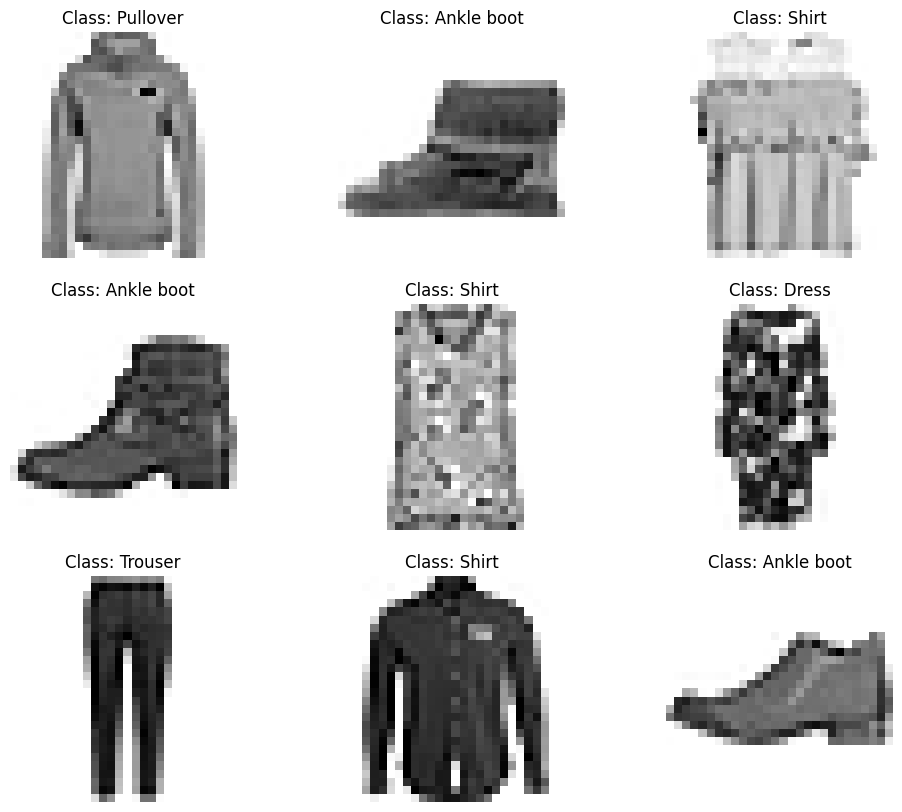

In [42]:
X_valid, y_valid = valid_set_raw

plt.figure(figsize=(12, 10))
for index, (image, label) in enumerate(zip(X_valid[:9], y_valid[:9])):
    plt.subplot(3, 3, index + 1)
    plt.imshow(image[..., 0], cmap="binary")
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

Los tres conjuntos de datos contienen imágenes individuales. Necesitamos agruparlos en lotes, pero para esto primero debemos asegurarnos de que todos tengan el mismo tamaño, de lo contrario, el agrupamiento no funcionará. Podemos usar una capa `Resizing` para esto. También debemos llamar a la función `tf.keras.applications.xception`.`preprocess_input()` para preprocesar las imágenes adecuadamente para el modelo Xception. También agregaremos barajar y precargar al conjunto de datos de entrenamiento.

In [43]:
tf.keras.backend.clear_session()
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

def preprocess_data(X, y):
    X = tf.image.grayscale_to_rgb(X)
    X = preprocess(X)
    return X, y
train_set = tf.data.Dataset.from_tensor_slices(train_set_raw).map(preprocess_data).shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = tf.data.Dataset.from_tensor_slices(valid_set_raw).map(preprocess_data).batch(batch_size)
test_set = tf.data.Dataset.from_tensor_slices(test_set_raw).map(preprocess_data).batch(batch_size)

Echemos un vistazo nuevamente a las primeras 9 imágenes del conjunto de validación: ahora son todas de 224x224, con valores que van de -1 a 1:

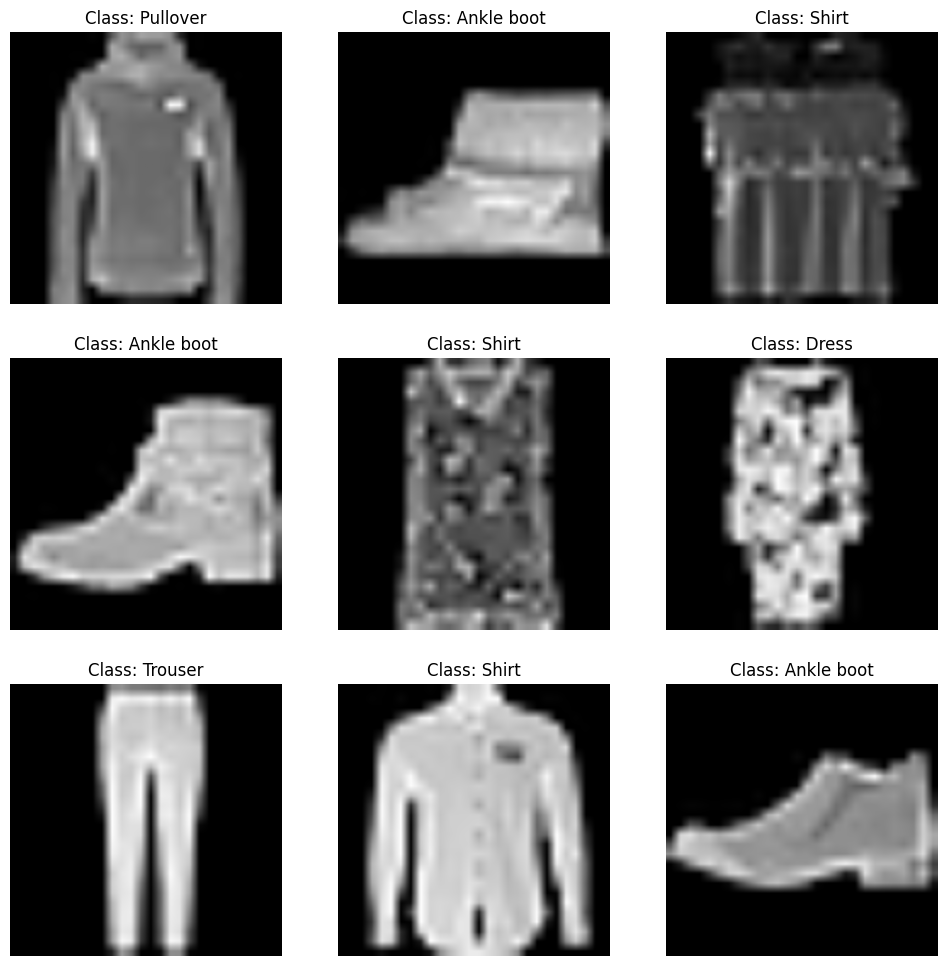

In [44]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")
plt.show()

In [45]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Intente ejecutar la siguiente celda varias veces para ver diferentes aumentos de datos aleatorios:

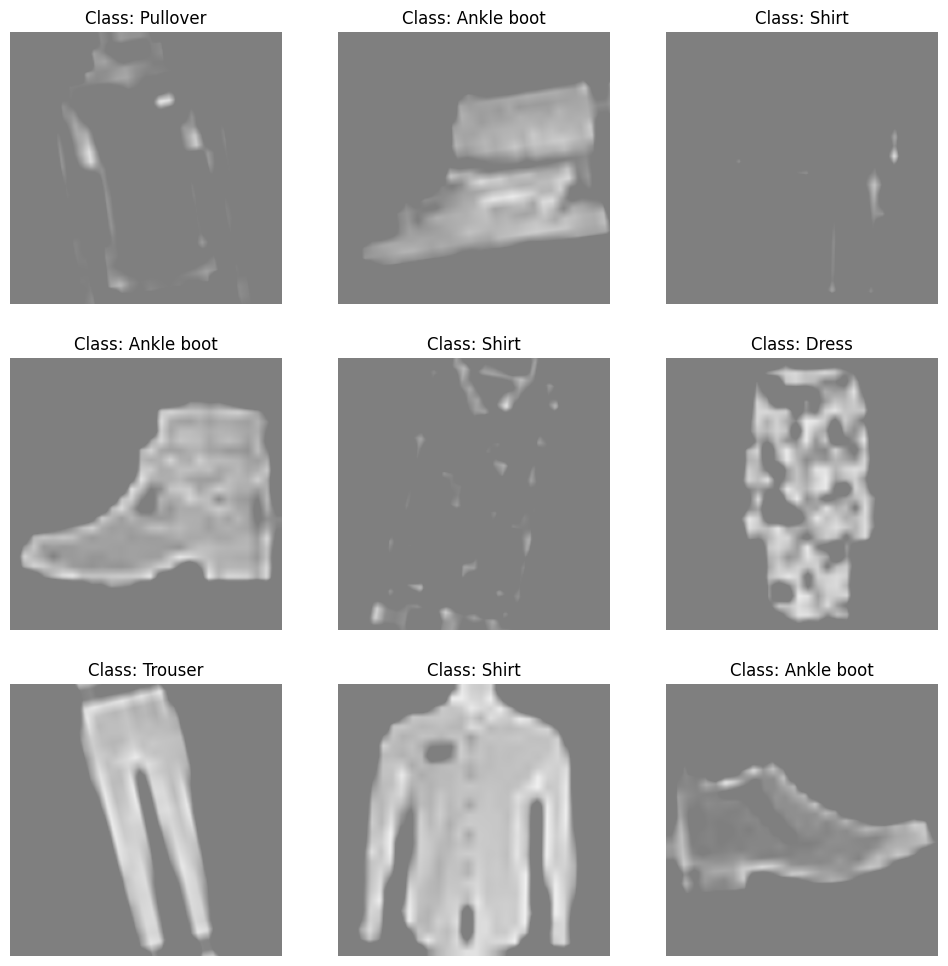

In [46]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

Ahora, carguemos el modelo previamente entrenado, sin sus capas superiores, y reemplácelas con las nuestras, para la tarea de clasificación de flores:

In [47]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 5s 0us/step


In [48]:
for layer in base_model.layers:
    layer.trainable = False

Entrenemos el modelo durante algunas épocas, mientras mantenemos fijos los pesos del modelo base:

In [49]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_set, epochs=2, validation_data=valid_set)

Epoch 1/2
1407/1407 [==============================] - 244s 170ms/step - loss: 0.4596 - accuracy: 0.8386 - val_loss: 0.3604 - val_accuracy: 0.8707
Epoch 2/2
1407/1407 [==============================] - 239s 170ms/step - loss: 0.3520 - accuracy: 0.8747 - val_loss: 0.3535 - val_accuracy: 0.8727


In [50]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Ahora que los pesos de nuestras nuevas capas superiores no son tan malos, podemos volver a entrenar la parte superior del modelo base y continuar entrenando, pero con una tasa de aprendizaje más baja:

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
1407/1407 [==============================] - 460s 319ms/step - loss: 0.2485 - accuracy: 0.9113 - val_loss: 0.1816 - val_accuracy: 0.9336
Epoch 2/10
1407/1407 [==============================] - 446s 316ms/step - loss: 0.1178 - accuracy: 0.9570 - val_loss: 0.1754 - val_accuracy: 0.9392
Epoch 3/10
1407/1407 [==============================] - 445s 316ms/step - loss: 0.0606 - accuracy: 0.9780 - val_loss: 0.2103 - val_accuracy: 0.9357
Epoch 4/10
1407/1407 [==============================] - 448s 318ms/step - loss: 0.0398 - accuracy: 0.9860 - val_loss: 0.2152 - val_accuracy: 0.9423
Epoch 5/10
 814/1407 [================>.............] - ETA: 2:51 - loss: 0.0257 - accuracy: 0.9912

### Implementación de una CNN con Xception
Arquitectura Xception pre-entrenada, Clasificación y Localización.

In [ ]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])

In [ ]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=["accuracy"])

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

# Evaluación de modelos de detección de objetos
Cómo se relaciona mAP con Precision/Recall

In [ ]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

In [ ]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()

# Prueba con Imagenes Nuevas

In [ ]:
import urllib.request
from PIL import Image
import numpy as np

image_urls = [
    'https://www.paris.cl/dw/image/v2/BCHW_PRD/on/demandware.static/-/Sites-cencosud-master-catalog/default/dwc18f58f4/images/imagenes-productos/601/405238-0001-001.jpg?sw=1480&sh=2000&sm=fit',
    'https://www.paris.cl/dw/image/v2/BCHW_PRD/on/demandware.static/-/Sites-cencosud-master-catalog/default/dw5f2d8343/images/imagenes-productos/604/483133-0340-001.jpg?sw=1480&sh=2000&sm=fit',
    'https://img.ltwebstatic.com/images3_pi/2022/07/20/1658302042fa7632a7bdec746dfcbdb140885ff22f_thumbnail_600x.jpg',
    'https://img.ltwebstatic.com/images3_pi/2022/12/05/1670204316f4be01b1c3210be8d8a326adab48a67d_thumbnail_600x.jpg',
    'https://img.ltwebstatic.com/images3_pi/2023/02/23/1677132256ff28e3aac890620fda50fa64a97acc2f_thumbnail_600x.jpg',
    'https://img.ltwebstatic.com/images3_pi/2023/01/11/1673422430eec29160b315045f67a7980f9d1e9bb8_thumbnail_600x.jpg',
    'https://img.ltwebstatic.com/images3_pi/2020/12/05/160713568464dc038bf7129c53ab7346f8970353e0.webp',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTiXy9jUjQeVo6yF8aMiccKlgxqXPiD06O_0J5UPCkr0hZAnbTMx5OxA1EuetxBG5B3wGs&usqp=CAU',
    'https://assets.adidas.com/images/h_840,f_auto,q_auto,fl_lossy,c_fill,g_auto/78b76ab3632d4251a7f2ae2b005fb600_9366/Zapatillas_adidas_Grand_Court_TD_Blanco_GW9250_01_standard.jpg',
    'https://static.theline.cl/img/products/DV0427-100-1_1024.png',
    # 'https://example.com/image11.jpg',
    # 'https://example.com/image12.jpg',
    # 'https://example.com/image13.jpg',
    # 'https://example.com/image14.jpg',
    # 'https://example.com/image15.jpg',
    # 'https://example.com/image16.jpg',
    # 'https://example.com/image17.jpg',
    # 'https://example.com/image18.jpg',
    # 'https://example.com/image19.jpg',
    # 'https://example.com/image20.jpg',
    # 'https://example.com/image21.jpg',
    # 'https://example.com/image22.jpg',
    # 'https://example.com/image23.jpg',
    # 'https://example.com/image24.jpg',
    # 'https://example.com/image25.jpg'
]

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    urllib.request.urlretrieve(image_urls[i], f'sample_image_{i+1}.jpg')

    image_ori = Image.open(f'sample_image_{i+1}.jpg')

    image = image_ori.resize((28, 28))
    image = image.convert('L')
    image = np.array(image)
    image = image.reshape(1, 28, 28, 1)

    prediction = model.predict(image)
    predicted_label = np.argmax(prediction)
    predicted_etiqueta = class_names[predicted_label]

    ax.imshow(image.squeeze(), cmap=plt.cm.binary, alpha=0.9)
    ax.imshow(image_ori.resize((28, 28)), alpha=0.1)
    ax.axis('off')
    ax.text(0.5, -0.15, predicted_etiqueta, color='red', fontsize=12, ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

Bla bla

# Conclusiones

1. Estas son las principales ventajas de una CNN sobre una DNN totalmente conectada para la clasificación de imágenes:
    * Debido a que las capas consecutivas solo están parcialmente conectadas y debido a que reutiliza en gran medida sus pesos, una CNN tiene muchos menos parámetros que una DNN completamente conectada, lo que hace que sea mucho más rápido de entrenar, reduce el riesgo de sobreajuste y requiere muchos menos datos de entrenamiento.
    * Cuando una CNN ha aprendido un kernel que puede detectar una característica en particular, puede detectar esa característica en cualquier parte de la imagen. Por el contrario, cuando un DNN aprende una función en una ubicación, puede detectarla solo en esa ubicación en particular. Dado que las imágenes suelen tener características muy repetitivas, las CNN pueden generalizar mucho mejor que las DNN para tareas de procesamiento de imágenes como la clasificación, utilizando menos ejemplos de capacitación.
    * Finalmente, un DNN no tiene conocimiento previo de cómo se organizan los píxeles; no sabe que los píxeles cercanos están cerca. La arquitectura de una CNN incorpora este conocimiento previo. Las capas inferiores suelen identificar características en áreas pequeñas de las imágenes, mientras que las capas superiores combinan las características de nivel inferior en características más grandes. Esto funciona bien con la mayoría de las imágenes naturales, lo que le da a las CNN una ventaja decisiva en comparación con las DNN..
2. Calculemos cuántos parámetros tiene la CNN.
    * Dado que su primera capa convolucional tiene núcleos de 3 × 3 y la entrada tiene tres canales (rojo, verde y azul), cada mapa de características tiene pesos de 3 × 3 × 3, más un término de sesgo. Son 28 parámetros por mapa de funciones. Dado que esta primera capa convolucional tiene 100 mapas de características, tiene un total de 2800 parámetros. La segunda capa convolucional tiene 3 × 3 kernels y su entrada es el conjunto de 100 mapas de características de la capa anterior, por lo que cada mapa de características tiene 3 × 3 × 100 = 900 pesos, más un término de sesgo. Como tiene 200 mapas de características, esta capa tiene 901 × 200 = 180 200 parámetros. Finalmente, la tercera y última capa convolucional también tiene kernels 3 × 3, y su entrada es el conjunto de 200 mapas de características de las capas anteriores, por lo que cada mapa de características tiene 3 × 3 × 200 = 1800 pesos, más un término de sesgo. Como tiene 400 mapas de características, esta capa tiene un total de 1.801 × 400 = 720.400 parámetros. En total, la CNN tiene 2800 + 180 200 + 720 400 = 903 400 parámetros.<br/>
    * Ahora calculemos cuánta RAM requerirá esta red neuronal (al menos) al hacer una predicción para una sola instancia. Primero calculemos el tamaño del mapa de características para cada capa. Dado que estamos usando un paso de 2 y un relleno `"mismo"`, las dimensiones horizontales y verticales de los mapas de características se dividen por 2 en cada capa (redondeando hacia arriba si es necesario). Entonces, como los canales de entrada son 200 × 300 píxeles, los mapas de características de la primera capa son 100 × 150, los mapas de características de la segunda capa son 50 × 75 y los mapas de características de la tercera capa son 25 × 38. Dado que 32 bits son 4 bytes y la primera capa convolucional tiene 100 mapas de características, esta primera capa ocupa 4 × 100 × 150 × 100 = 6 millones de bytes (6 MB). La segunda capa ocupa 4 × 50 × 75 × 200 = 3 millones de bytes (3 MB). Finalmente, la tercera capa ocupa 4 × 25 × 38 × 400 = 1 520 000 bytes (alrededor de 1,5 MB). Sin embargo, una vez calculada una capa, se puede liberar la memoria que ocupaba la capa anterior, por lo que si todo está bien optimizado, solo se requerirán 6 + 3 = 9 millones de bytes (9 MB) de RAM (cuando la segunda capa haya terminado. recién computado, pero la memoria ocupada por la primera capa aún no ha sido liberada). Pero espera, ¡también necesitas agregar la memoria ocupada por los parámetros de la CNN! Calculamos anteriormente que tiene 903 400 parámetros, cada uno de los cuales usa 4 bytes, por lo que esto agrega 3 613 600 bytes (alrededor de 3,6 MB). Por lo tanto, la RAM total requerida es (al menos) 12,613,600 bytes (alrededor de 12.6 MB).<br/>
    * Por último, calculemos la cantidad mínima de RAM requerida al entrenar la CNN en un mini lote de 50 imágenes. Durante el entrenamiento, TensorFlow usa retropropagación, lo que requiere mantener todos los valores calculados durante el paso hacia adelante hasta que comience el paso hacia atrás. Entonces, debemos calcular la RAM total requerida por todas las capas para una sola instancia y multiplicarla por 50. En este punto, comencemos a contar en megabytes en lugar de bytes. Calculamos antes que las tres capas requieren respectivamente 6, 3 y 1,5 MB para cada instancia. Eso es un total de 10,5 MB por instancia, por lo que para 50 instancias, la RAM total requerida es de 525 MB. Agregue a eso la RAM requerida por las imágenes de entrada, que es 50 × 4 × 200 × 300 × 3 = 36 millones de bytes (36 MB), más la RAM requerida para los parámetros del modelo, que es de aproximadamente 3,6 MB (calculado anteriormente), más algo de RAM para los gradientes (lo descuidaremos ya que puede liberarse gradualmente a medida que la retropropagación desciende por las capas durante el paso inverso). Tenemos un total de aproximadamente 525 + 36 + 3,6 = 564,6 MB, y eso es realmente un mínimo optimista.
3. Si su GPU se queda sin memoria mientras entrena una CNN, aquí hay cinco cosas que podría intentar para resolver el problema (además de comprar una GPU con más RAM):
    * Reducir el tamaño del mini lote.
    * Reducir la dimensionalidad usando una zancada más grande en una o más capas.
    * Eliminar una o más capas.
    * Use flotantes de 16 bits en lugar de flotantes de 32 bits.
    * Distribuir la CNN a través de múltiples dispositivos.
4. Una capa de agrupación máxima no tiene ningún parámetro, mientras que una capa convolucional tiene bastantes (consulte las preguntas anteriores).
5. Una capa de normalización de respuesta local hace que las neuronas que se activan con mayor fuerza inhiban las neuronas en la misma ubicación pero en mapas de características vecinos, lo que fomenta que los diferentes mapas de características se especialicen y los separa, obligándolos a explorar una gama más amplia de características. Por lo general, se usa en las capas inferiores para tener un grupo más grande de características de bajo nivel sobre las que se pueden construir las capas superiores.
6. Las principales innovaciones de AlexNet en comparación con LeNet-5 son que es mucho más grande y profunda, y apila capas convolucionales directamente una encima de la otra, en lugar de apilar una capa de agrupación encima de cada capa convolucional. La principal innovación en GoogLeNet es la introducción de _módulos de inicio_, que permiten tener una red mucho más profunda que las arquitecturas anteriores de CNN, con menos parámetros. La principal innovación de ResNet es la introducción de conexiones salteadas, que permiten ir mucho más allá de las 100 capas. Podría decirse que su simplicidad y consistencia también son bastante innovadoras. La principal innovación de SENet fue la idea de usar un bloque SE (una red densa de dos capas) después de cada módulo inicial en una red inicial o cada unidad residual en una ResNet para recalibrar la importancia relativa de los mapas de características. La principal innovación de Xception fue el uso de capas convolucionales separables en profundidad, que analizan los patrones espaciales y los patrones en profundidad por separado. Por último, la anotación principal de EfficientNet fue el método de escalado compuesto, para escalar de manera eficiente un modelo a un presupuesto informático más grande.
7. Las redes totalmente convolucionales son redes neuronales compuestas exclusivamente por capas convolucionales y de agrupación. Los FCN pueden procesar de manera eficiente imágenes de cualquier ancho y alto (al menos por encima del tamaño mínimo). Son más útiles para la detección de objetos y la segmentación semántica porque solo necesitan mirar la imagen una vez (en lugar de tener que ejecutar una CNN varias veces en diferentes partes de la imagen). Si tiene una CNN con algunas capas densas en la parte superior, puede convertir estas capas densas en capas convolucionales para crear una FCN: simplemente reemplace la capa densa más baja con una capa convolucional con un tamaño de núcleo igual al tamaño de entrada de la capa, con un filtro por neurona en la capa densa, y usando relleno `"válido"`. En general, la zancada debe ser 1, pero puede configurarlo en un valor más alto si lo desea. La función de activación debe ser la misma que la de la capa densa. Las otras capas densas deben convertirse de la misma manera, pero usando filtros 1 × 1. De hecho, es posible convertir una CNN entrenada de esta manera remodelando adecuadamente las matrices de peso de las capas densas.
8. La principal dificultad técnica de la segmentación semántica es el hecho de que gran parte de la información espacial se pierde en una CNN a medida que la señal fluye a través de cada capa, especialmente en capas agrupadas y capas con un paso superior a 1. Esta información espacial debe ser restaurado de alguna manera para predecir con precisión la clase de cada píxel.